# Run ensemble model and submit predictions

### Imports

In [1]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if 'adrian_sensorium' not in os.getcwd():
    os.chdir('adrian_sensorium')
print('Working directory:', os.getcwd())

Working directory: d:\Python\Anastasia\Petreanu Lab\adrian_sensorium


In [2]:
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model, get_trainer
import torch

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm


import warnings

warnings.filterwarnings('ignore')

### Load configuration for model

In [3]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

### Prepare dataloader

In [4]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE09665/2023_03_20',
 'notebooks/data/IM_prezipped/LPE10883/2023_10_23',
 'notebooks/data/IM_prezipped/LPE10883/2023_10_31',
 'notebooks/data/IM_prezipped/LPE10884/2023_10_12',
 'notebooks/data/IM_prezipped/LPE10885/2023_10_20',
 'notebooks/data/IM_prezipped/LPE10919/2023_11_09',
 'notebooks/data/IM_prezipped/LPE11086/2023_12_16',
 'notebooks/data/IM_prezipped/LPE11086/2024_01_09',
 'notebooks/data/IM_prezipped/LPE11495/2024_02_29',
 'notebooks/data/IM_prezipped/LPE12223/2024_06_11']

In [5]:
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

### Load trained models

In [6]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

### Combine them into one ensemble model

In [7]:
from sensorium.models.ensemble import EnsemblePrediction

In [8]:
ensemble = EnsemblePrediction(model_list, mode='mean')

### Generate submission file

In [9]:
""" dataset_name = '27204-5-13'

submission.generate_submission_file(trained_model=ensemble, 
                                    dataloaders=dataloaders,
                                    data_key=dataset_name,
                                    path="notebooks/submission_m4/results/",
                                    device="cuda") """

' dataset_name = \'27204-5-13\'\n\nsubmission.generate_submission_file(trained_model=ensemble, \n                                    dataloaders=dataloaders,\n                                    data_key=dataset_name,\n                                    path="notebooks/submission_m4/results/",\n                                    device="cuda") '

### Evaluate model on all datasets

In [10]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [11]:
single_trial_correlation = get_correlations(
    ensemble, dataloaders, tier="validation", device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                       measure_attribute="Single Trial Correlation"
                       )

In [12]:
%matplotlib inline

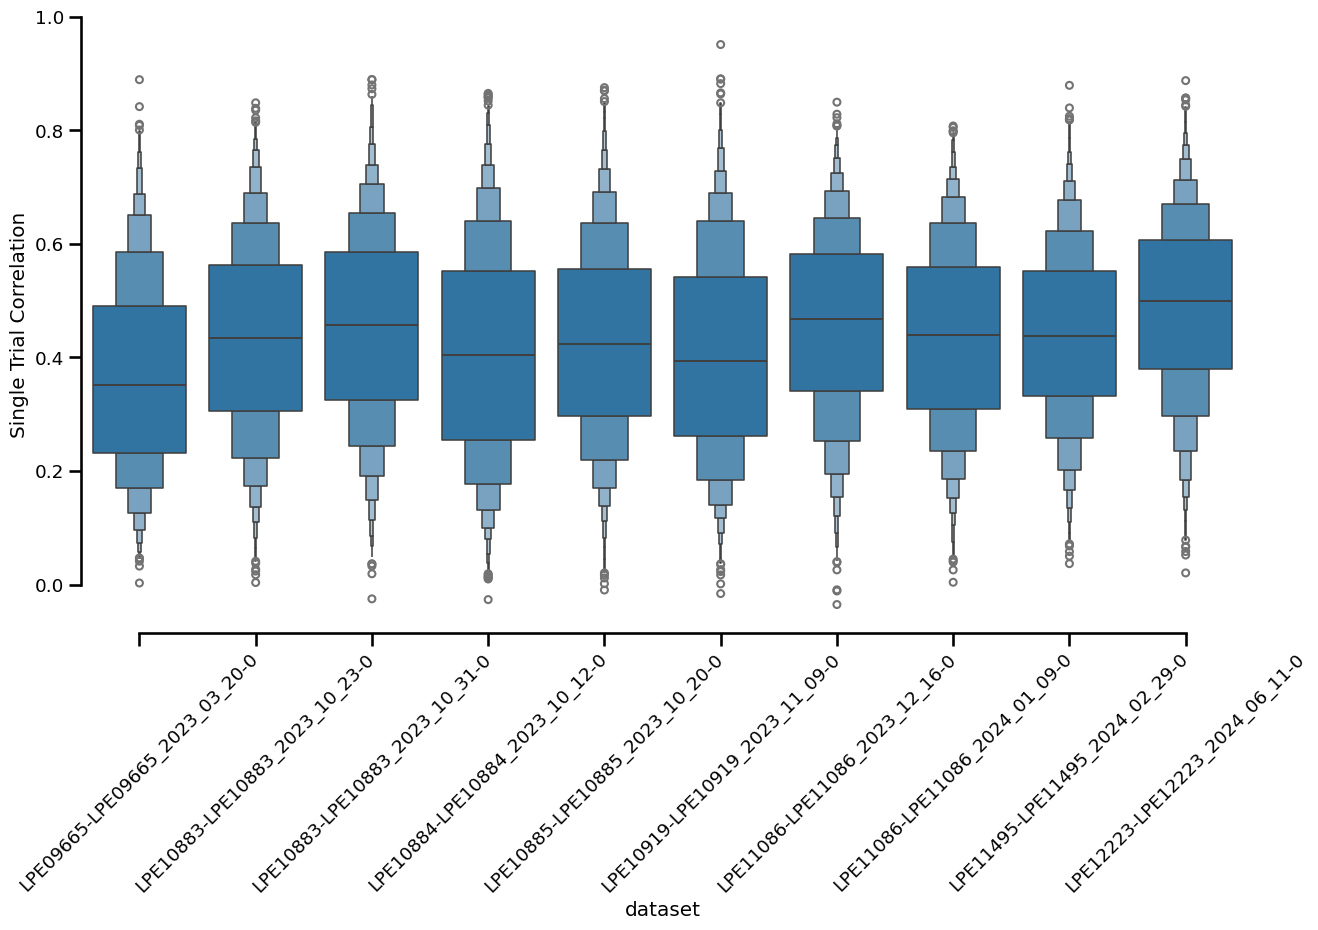

In [53]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
sns.despine(trim=True)
plt.savefig('notebooks/submission_m4/results/single_trial_correlations_box.png')
plt.show()

In [19]:
os.getcwd()

'd:\\Python\\Anastasia\\Petreanu Lab\\adrian_sensorium'

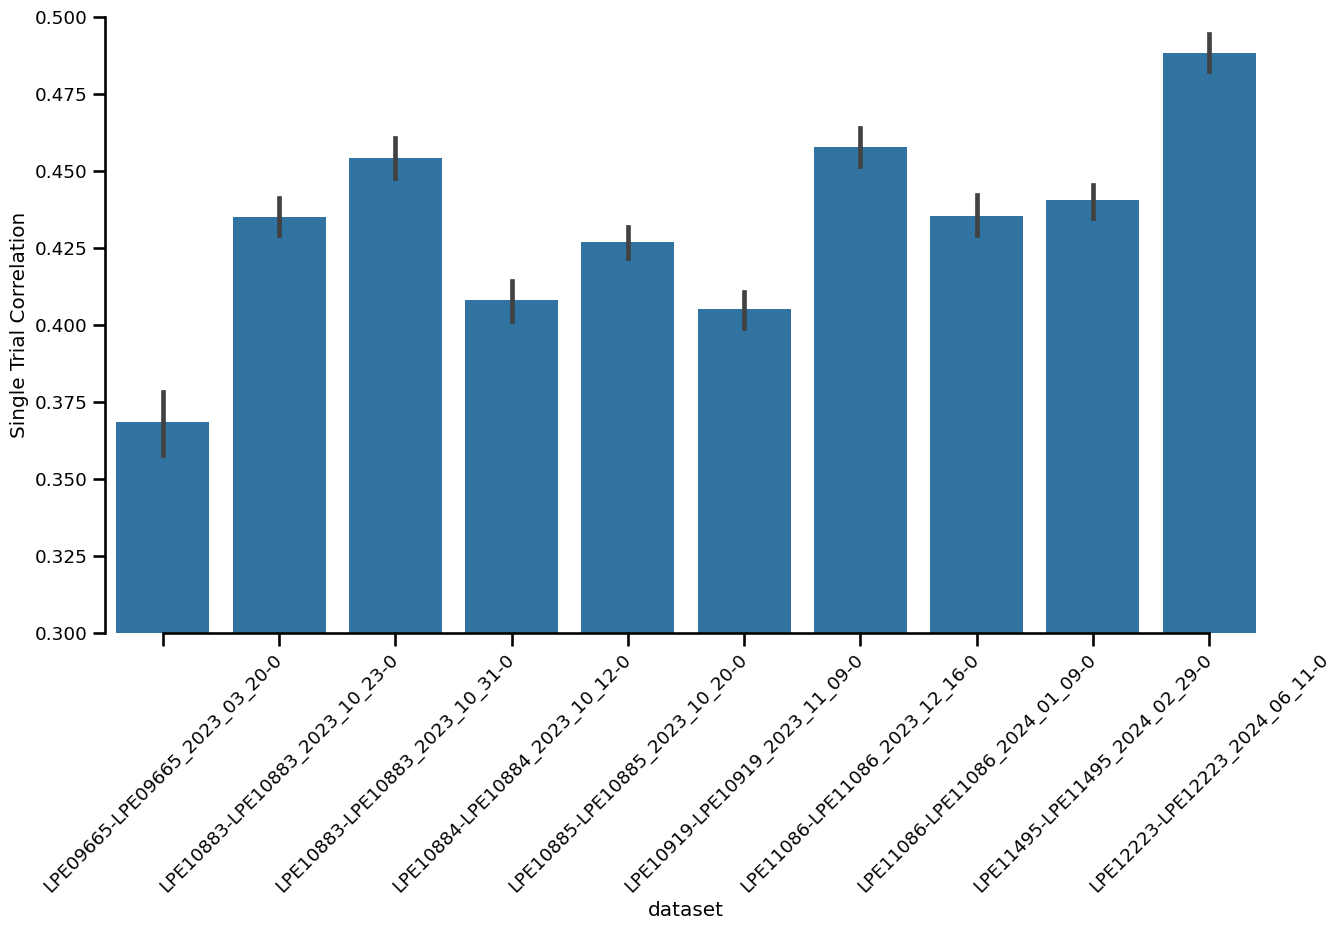

In [54]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
plt.ylim(0.3, 0.5)
sns.despine(trim=True)
plt.savefig('notebooks/submission_m4/results/single_trial_correlations_hist.png')
plt.show()

In [51]:
df_desc = df.groupby('dataset').describe()
df_desc.loc[("All datasets", )] = df_desc.mean()
# I'm so sorry about this horrible one liner
df_desc.loc[("All datasets, weighted"), ] = df_desc['Single Trial Correlation'].mul((df_desc['Single Trial Correlation']['count'].values.reshape(-1, 1)) / np.sum(df_desc['Single Trial Correlation']['count'].values)).sum().values
df_desc.to_csv('notebooks/submission_m4/results/validation_pred_description.csv')
df_desc

Single Trial Correlation                      \
                                                  count      mean       std   
dataset                                                                       
LPE09665-LPE09665_2023_03_20-0               1041.00000  0.368279  0.168810   
LPE10883-LPE10883_2023_10_23-0               2599.00000  0.435018  0.167989   
LPE10883-LPE10883_2023_10_31-0               2470.00000  0.454060  0.168869   
LPE10884-LPE10884_2023_10_12-0               3246.00000  0.407993  0.186084   
LPE10885-LPE10885_2023_10_20-0               4169.00000  0.426855  0.170083   
LPE10919-LPE10919_2023_11_09-0               3273.00000  0.404962  0.179504   
LPE11086-LPE11086_2023_12_16-0               2585.00000  0.457561  0.161353   
LPE11086-LPE11086_2024_01_09-0               2432.00000  0.435370  0.160766   
LPE11495-LPE11495_2024_02_29-0               2974.00000  0.440410  0.151130   
LPE12223-LPE12223_2024_06_11-0               2663.00000  0.488285  0.155077   
All datasets                                 2745.20000  0.431879  0.166966   
All datasets, weighted                       2935.31205  0.433886  0.167530   

                                                                        \
                                     min       25%       50%       75%   
dataset                                                                  
LPE09665-LPE09665_2023_03_20-0  0.002900  0.232623  0.352198  0.490119   
LPE10883-LPE10883_2023_10_23-0  0.003744  0.305998  0.434560  0.562027   
LPE10883-LPE10883_2023_10_31-0 -0.025007  0.325439  0.457132  0.585971   
LPE10884-LPE10884_2023_10_12-0 -0.026330  0.254952  0.404398  0.552924   
LPE10885-LPE10885_2023_10_20-0 -0.009479  0.296553  0.423031  0.556196   
LPE10919-LPE10919_2023_11_09-0 -0.015734  0.261554  0.393361  0.541113   
LPE11086-LPE11086_2023_12_16-0 -0.035038  0.341048  0.466899  0.582153   
LPE11086-LPE11086_2024_01_09-0  0.004165  0.309530  0.439150  0.559111   
LPE11495-LPE11495_2024_02_29-0  0.036971  0.331976  0.438548  0.551896   
LPE12223-LPE12223_2024_06_11-0  0.020646  0.380464  0.498779  0.606173   
All datasets                   -0.004316  0.304014  0.430806  0.558768   
All datasets, weighted         -0.005062  0.305681  0.433120  0.561543   

                                          
                                     max  
dataset                                   
LPE09665-LPE09665_2023_03_20-0  0.889064  
LPE10883-LPE10883_2023_10_23-0  0.848345  
LPE10883-LPE10883_2023_10_31-0  0.889377  
LPE10884-LPE10884_2023_10_12-0  0.864924  
LPE10885-LPE10885_2023_10_20-0  0.875081  
LPE10919-LPE10919_2023_11_09-0  0.950908  
LPE11086-LPE11086_2023_12_16-0  0.849455  
LPE11086-LPE11086_2024_01_09-0  0.807525  
LPE11495-LPE11495_2024_02_29-0  0.879086  
LPE12223-LPE12223_2024_06_11-0  0.887399  
All datasets                    0.874116  
All datasets, weighted          0.875317